In [72]:
from math import ceil
from omegaconf import OmegaConf
from sampler import BaseSampler
from utils import util_common
from utils import util_image
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision as thv

In [52]:
class DiffusionSampler(BaseSampler):
    def sample_func(self, noise=None, start_timesteps=None, bs=4, num_images=1000, save_dir=None):
        print('Begining sampling:')

        h = w = self.configs.im_size
        if self.num_gpus != 0:
            total_iters = ceil(num_images / (bs * self.num_gpus))
        else:
            total_iters = ceil(num_images / (bs * 1))
        for ii in range(total_iters):
            if self.rank == 0 and self.display:
                print(f'Processing: {ii+1}/{total_iters}')
            if noise == None:
                if self.num_gpus != 0:
                    noise = torch.randn((bs, 1, h, w), dtype=torch.float32).cuda()
                else:
                    noise = torch.randn((bs, 1, h, w), dtype=torch.float32)
            if 'ddim' in self.configs.diffusion.params.timestep_respacing:
                sample = self.diffusion.ddim_sample_loop(
                        self.model,
                        shape=(bs, 1, h, w),
                        noise=noise,
                        start_timesteps=start_timesteps,
                        clip_denoised=True,
                        denoised_fn=None,
                        model_kwargs=None,
                        device=None,
                        progress=False,
                        eta=0.0,
                        )
            else:
                sample = self.diffusion.p_sample_loop(
                        self.model,
                        shape=(bs, 1, h, w),
                        noise=noise,
                        start_timesteps=start_timesteps,
                        clip_denoised=True,
                        denoised_fn=None,
                        model_kwargs=None,
                        device=None,
                        progress=False,
                        )
            sample = util_image.normalize_th(sample, reverse=True).clamp(0.0, 1.0)
        return sample

In [3]:
planaria_data = np.load('/Users/schaudhary/siva_projects/Denoising_Planaria/train_data/data_label.npz')
planaria_data_Y = planaria_data['Y']
planaria_data_X = planaria_data['X']

In [107]:
def plot_image_row(images, names=None):
    fig, ax = plt.subplots(1, len(images), figsize=(5*len(images), 5))
    for i in range(len(images)):
        ax[i].imshow(images[i][0, 0])
        ax[i].axis('off')
        if names != None:
            ax[i].set_title(names[i])

def plot_denoise_example(y0, xN_given_y0, x0_sampled, x0):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(y0[0, 0])
    ax[1].imshow(xN_given_y0[0, 0])
    ax[2].imshow(x0_sampled[0, 0])
    ax[3].imshow(x0[0, 0])
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[0].set_title('noisy')
    ax[1].set_title('noisy_forward')
    ax[2].set_title('denoised')
    ax[3].set_title('gt')

In [73]:
transform = thv.transforms.Normalize(mean=(0.5), std=(0.5))

# simple denoising

In [159]:
cfg_path = '/Users/schaudhary/siva_projects/DifFace/configs/sample/iddpm_care_planaria_2D.yaml'
gpu_id = ''
timestep_respacing = '1000'
bs = 1
num_images = 1
save_dir = ''

configs = OmegaConf.load(cfg_path)
configs.gpu_id = gpu_id
configs.diffusion.params.timestep_respacing = timestep_respacing

sampler_dist = DiffusionSampler(configs)


In [160]:
tN = torch.tensor(500)
y0 = transform(torch.tensor(planaria_data_X[150:151, 0, 10:11], dtype=torch.float32))
x0 = torch.tensor(planaria_data_Y[150:151, 0, 10:11], dtype=torch.float32)
xN_given_y0 = sampler_dist.diffusion.q_sample(y0, tN)
x0_sampled = sampler_dist.sample_func(noise=xN_given_y0, start_timesteps=tN, bs=bs, num_images=num_images, save_dir=save_dir)

Begining sampling:


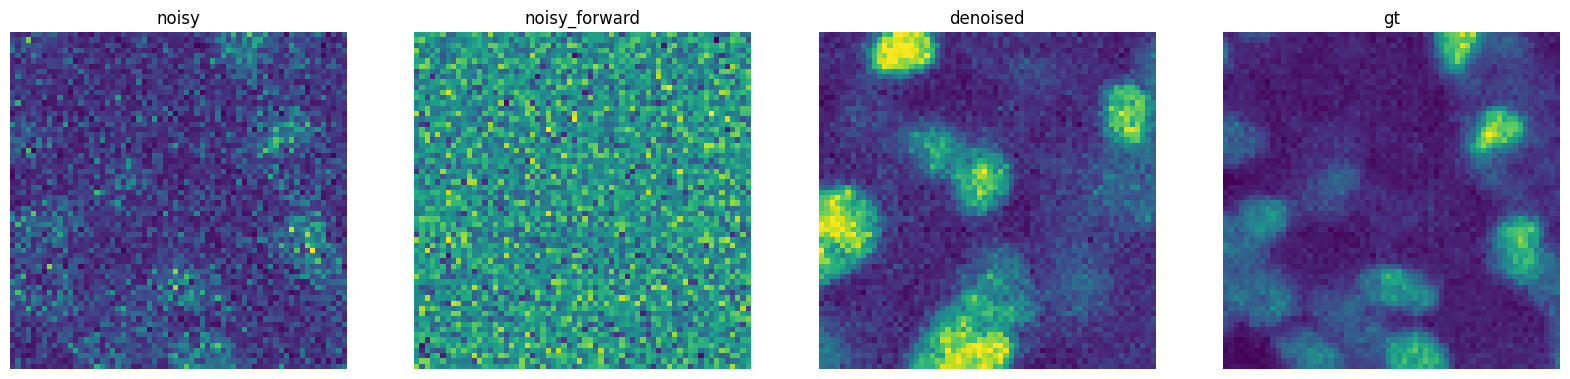

In [161]:
plot_denoise_example(y0, xN_given_y0, x0_sampled, x0)

# denoise by mixing

In [104]:
cfg_path = '/Users/schaudhary/siva_projects/DifFace/configs/sample/iddpm_care_planaria_2D.yaml'
gpu_id = ''
timestep_respacing = '1000'
bs = 1
num_images = 1
save_dir = ''

configs = OmegaConf.load(cfg_path)
configs.gpu_id = gpu_id
configs.diffusion.params.timestep_respacing = timestep_respacing

sampler_dist = DiffusionSampler(configs)

In [184]:
def linear_mixing_alphas(min_alpha, max_alpha, n_steps):
    mixing_alphas = np.linspace(min_alpha, max_alpha, n_steps - 1)
    return mixing_alphas

def constant_mixing_alphas(alpha, n_steps):
    mixing_alphas = [alpha for i in range(n_steps - 1)]
    return mixing_alphas

tN = torch.tensor(500)
y0 = transform(torch.tensor(planaria_data_X[150:151, 0, 10:11], dtype=torch.float32))
x0 = torch.tensor(planaria_data_Y[150:151, 0, 10:11], dtype=torch.float32)
n_steps = 5
assert tN % n_steps == 0
mixing_t_steps = {i*int(tN/n_steps):i for i in range(1, n_steps)}
# mixing_alphas = constant_mixing_alphas(0.5, n_steps)
mixing_alphas = linear_mixing_alphas(0.01, 0.99, n_steps)
mixing_xN_given_y0 = [sampler_dist.diffusion.q_sample(y0, torch.tensor(step)) for step in mixing_t_steps]
xN_given_y0 = sampler_dist.diffusion.q_sample(y0, tN - 1)
img = xN_given_y0

h = w = configs.im_size
shape = (bs, 1, h, w)
indices = list(range(tN)[::-1])
for i in indices:
    t = torch.tensor([i] * shape[0], device=y0.device)
    with torch.no_grad():
        out = sampler_dist.diffusion.p_sample(
            sampler_dist.model,
            img,
            t,
            clip_denoised=True,
            denoised_fn=None,
            model_kwargs=None,
        )
        img = out["sample"]
    
    if i in mixing_t_steps:
        print(f'mixing at {i}', (1 - mixing_alphas[mixing_t_steps[i] - 1]), mixing_alphas[mixing_t_steps[i] - 1])
        img = (1 - mixing_alphas[mixing_t_steps[i] - 1])*img + mixing_alphas[mixing_t_steps[i] - 1]*mixing_xN_given_y0[mixing_t_steps[i] - 1]
        


mixing at 400 0.010000000000000009 0.99
mixing at 300 0.33666666666666667 0.6633333333333333
mixing at 200 0.6633333333333333 0.33666666666666667
mixing at 100 0.99 0.01


In [182]:
mixing_alphas

array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   , 0.6225, 0.745 , 0.8675,
       0.99  ])

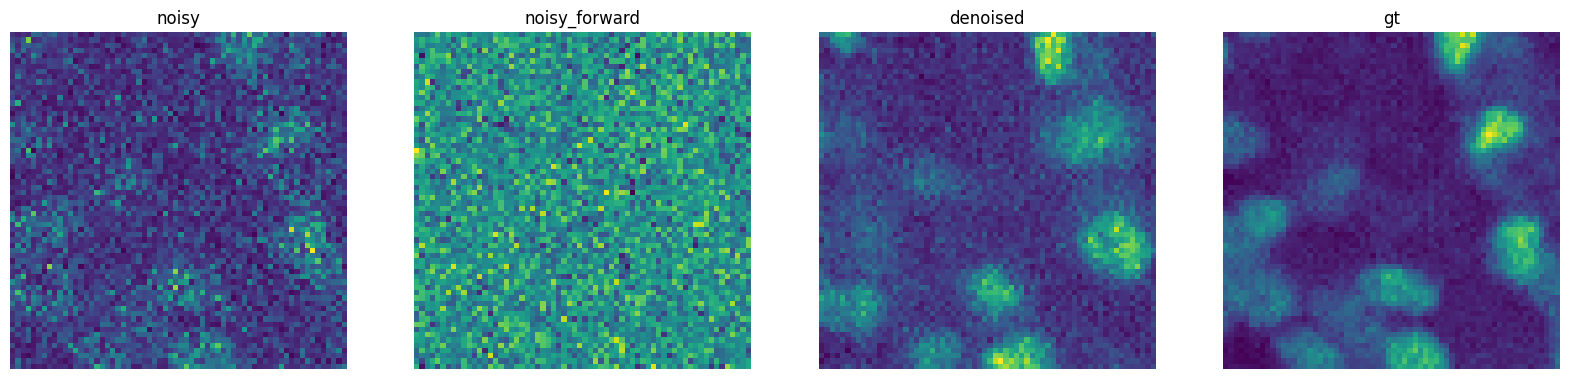

In [185]:
plot_denoise_example(y0, xN_given_y0, img, x0)